# Gaussian Mixture Model (Dummy dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# data filenames
data_filename   = './dummy_data_d.csv'
trace_filename  = './traces/trace_dummy'

## Load dataset, import and plot samples

In [28]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
27,0.591614,-0.076361,-0.095934,-0.182043,0.278793,0.062935,0.258603,-0.465403,0.586594,-0.113949,...,0.639030,0.345786,0.390042,0.109085,0.385303,0.426988,-0.028205,0.183897,1.115211,A
15,-0.584912,0.268772,-1.210942,-0.164853,-0.400786,0.311229,0.512476,0.255228,-0.723511,-0.618342,...,-0.136816,0.219174,0.703282,-0.144051,-0.090843,0.813341,0.171100,-0.304084,0.352570,A
23,-1.112893,-0.036519,-0.101091,-0.457544,-0.109797,0.999589,-0.208036,-0.713992,0.161993,0.055805,...,5.920103,4.063530,4.238133,3.310914,4.363631,3.934677,2.185067,2.095967,3.238929,B
17,0.620253,0.026734,0.144848,0.120004,-0.162408,-0.172506,-0.843313,1.202692,-0.589038,0.471504,...,0.329203,0.620741,-0.156941,1.185543,0.266668,0.372400,0.105053,0.009576,-0.229713,A
8,-0.429087,-0.046400,-0.309158,0.011082,-0.076295,-0.349915,0.839916,-0.084057,-0.190697,0.320323,...,-0.055283,0.289666,1.438772,0.075344,0.217084,0.379762,-0.177842,0.963224,-0.021009,A


A: blue
B: red


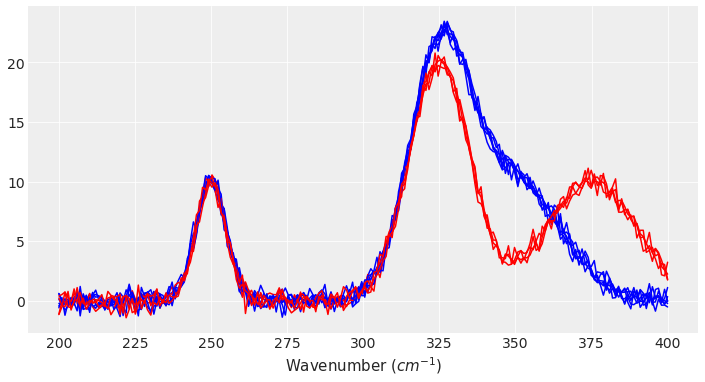

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# number of classes
nclasses = len(class_labels)

# plot dataframe
utl.plot_data(data_obj, 10)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

B    15
A    15
Name: label, dtype: int64


# Model definition (Gaussian Mixture)

In [7]:
# store the data for the classes in a list of dataframes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

# 1D array of X values
x_val = np.array(data.columns[:data_obj.non_data_columns], dtype='float32').reshape(200,1)

# 2D array containing Y values (observation data)
x_n = data.columns[:data_obj.non_data_columns]
x_s = [df[i][x_n].values for i in range(len(df))]

In [8]:
peaks = [2,3]
traces = []
models = []

for npeaks in peaks:
    print("training on " + str(npeaks) + " peaks")
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(nclasses,npeaks))
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                       shape=(nclasses,npeaks), transform=pm.distributions.transforms.ordered)
        #mu = pm.Normal('mu', mu=x_val.mean(), sd=(x_val.max()-x_val.min())/2, shape=(1,npeaks), 
        #               testval=np.linspace(x_val.min(), x_val.max(), npeaks))
        sigma = pm.HalfNormal('sigma', sd=100, shape=(nclasses,npeaks))
        epsilon = pm.HalfNormal('epsilon', sd=1)

        y_a = pm.Deterministic('y_a', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2))).sum(axis=1))
        y_b = pm.Deterministic('y_b', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))).sum(axis=1))
        
        y_pred_a = pm.Normal('y_pred_a', mu=y_a, sd=epsilon, observed=x_s[0])
        y_pred_b = pm.Normal('y_pred_b', mu=y_b, sd=epsilon, observed=x_s[1])
        
        traces += [pm.sample(2000, init='adapt_diag', random_seed=42)]
        models += [model]

training on 2 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [09:12<00:00,  9.05draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9521263213043647, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8866583743696395, but should be close to 0.8. Try to increase the number of tuning steps.


training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [05:01<00:00, 16.58draws/s] 
The acceptance probability does not match the target. It is 0.9981951572680293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.998002766927089, but should be close to 0.8. Try to increase the number of tuning steps.


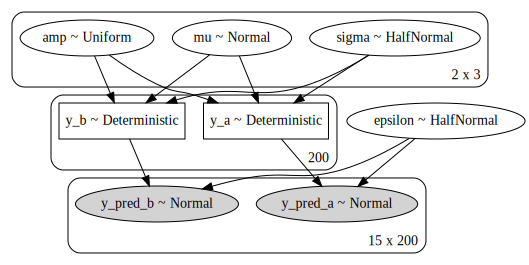

In [9]:
pm.model_to_graphviz(model)

# Model evaluation

In [10]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
#coef = az.summary(traces[0], varnames)
#coef

In [11]:
#az.plot_trace(traces[0], varnames, combined=True);
#az.plot_trace(traces[1], varnames);

In [12]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:02<00:00, 224.16it/s]


In [13]:
#data_ppc = az.from_pymc3(trace=trace, posterior_predictive=ppc)
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

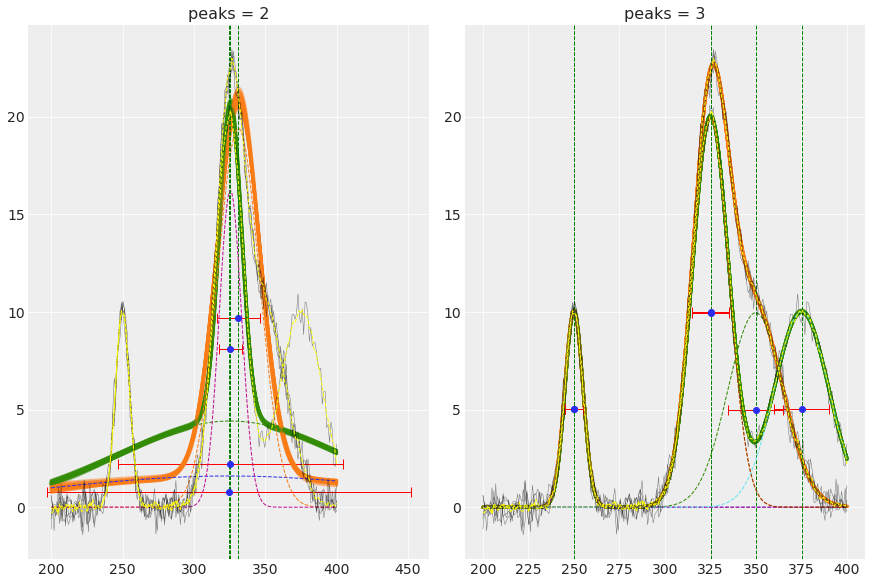

In [31]:
_, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)

for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred_a']
    #for i in range(1):
    #    ax[idx].plot(x_val, sp[i,0,:], 'o', color="blue", linewidth=1, alpha=.5)
    
    # plot samples from the posterior
    sp = ppc_x['y_pred_b']
    #for i in range(1):
    #    ax[idx].plot(x_val, sp[i,0,:], 'o', color="red", linewidth=1, alpha=.5)
        
    # plot samples from the posterior model formula
    for i in range(20):
        ax[idx].plot(x_val, traces[idx]['y_a'][i], color='C1', alpha=.5, linewidth=3);
        ax[idx].plot(x_val, traces[idx]['y_b'][i], color='C2', alpha=.5, linewidth=3);
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(5):
        y_val = data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '-', color="black", alpha=.5, linewidth=.5)
        
    # plot the mean of the real data
    for _, val in enumerate(df): 
        ax[idx].plot(x_val, val[data.columns[:data_obj.non_data_columns]].mean(), '--', color='yellow', linewidth=1);
    
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))

In [15]:
#comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
#comp

In [16]:
#az.plot_compare(comp);

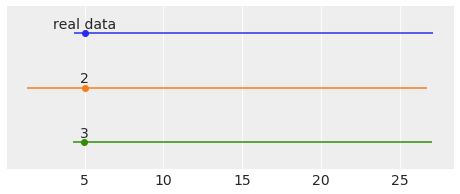

In [17]:
plt.figure(figsize=(8, 3))
data = [x_s[0]]
dd = [ppc_mm[i]['y_pred_a'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

In [18]:
for idx, trace in enumerate(traces):
    print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

2 peaks, bfmi: [1.03744199 0.96932934]
3 peaks, bfmi: [0.99332231 1.07237671]


In [19]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -(class A)---\n" + str(az.r2_score(x_s[0], ppc['y_pred_a'])))
    print("--- " + str(peaks[idx]) + " peaks -(class B)---\n" + str(az.r2_score(x_s[1], ppc['y_pred_b'])))

--- 2 peaks -(class A)---
r2        0.824962
r2_std    0.009165
dtype: float64
--- 2 peaks -(class B)---
r2        0.713486
r2_std    0.013053
dtype: float64
--- 3 peaks -(class A)---
r2        0.994289
r2_std    0.000361
dtype: float64
--- 3 peaks -(class B)---
r2        0.991567
r2_std    0.000524
dtype: float64


In [20]:
varnames = ['amp', 'mu', 'sigma', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 2 peaks ----------------------------------
               mean      sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]      1.599   0.120    1.382    1.834      0.003    0.002    1838.0   
amp[0,1]     19.392   0.199   19.019   19.750      0.004    0.003    2639.0   
amp[1,0]      4.413   0.100    4.218    4.592      0.002    0.001    2615.0   
amp[1,1]     16.231   0.258   15.728   16.716      0.005    0.003    2773.0   
mu[0,0]     324.353   5.407  314.840  331.238      0.155    0.109    1222.0   
mu[0,1]     331.153   0.178  330.818  331.471      0.003    0.002    3362.0   
mu[1,0]     325.471   0.147  325.188  325.731      0.003    0.002    3164.0   
mu[1,1]     325.533   0.133  325.271  325.769      0.002    0.001    4121.0   
sigma[0,0]  127.505  22.802   95.298  171.977      0.558    0.409    1672.0   
sigma[0,1]   14.850   0.210   14.474   15.244      0.004    0.003    2381.0   
sigma[1,0]   78.965   2.459   74.069   83.304      0.047    0.033    2773.0   
sigm


--- 2 peaks ----------------------------------

--- 3 peaks ----------------------------------


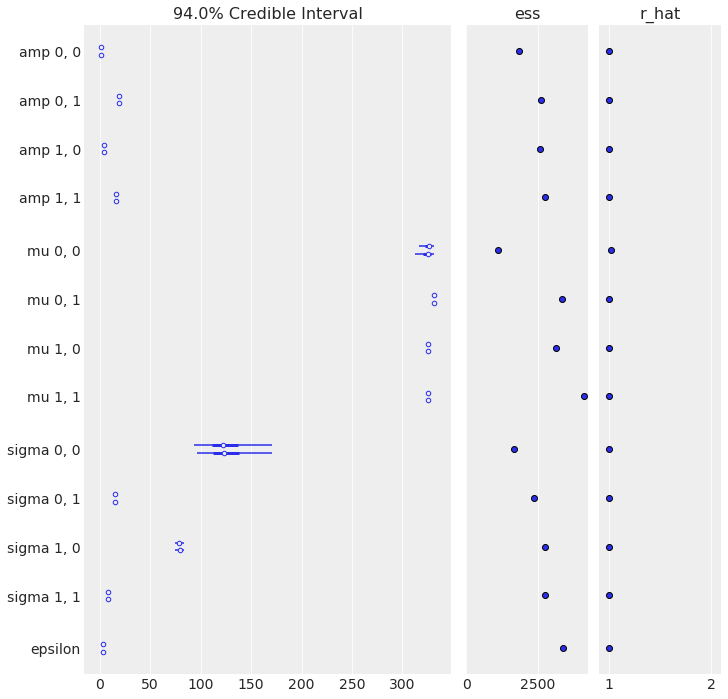

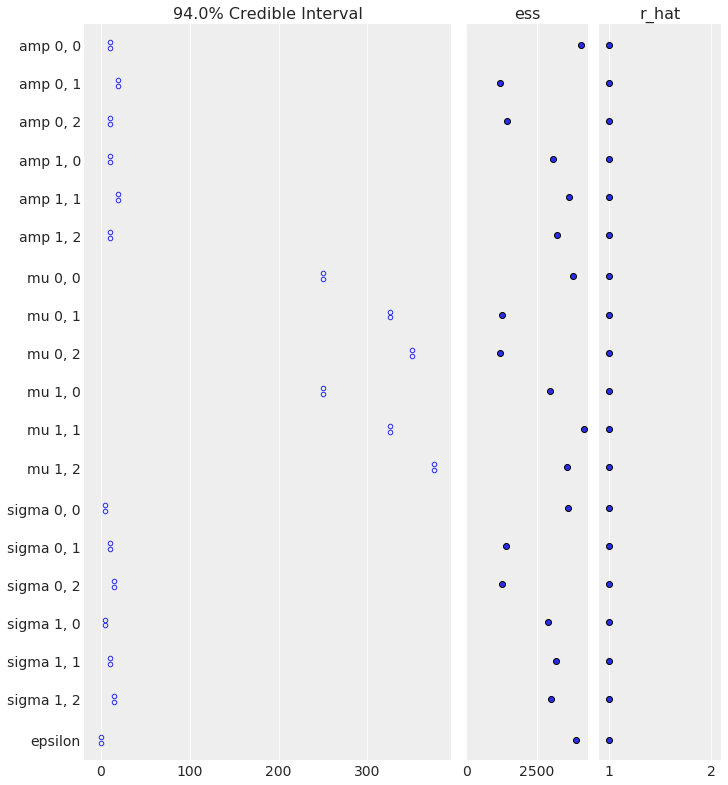

In [25]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon'], r_hat=True, ess=True);